# Foco da Analise, primeiras impressões


Realizar uma clusterização com as seguintes colunas, para compreender quais são os perfis de carros que mais alugados por cada perfil de cliente: 
        'Tipo do cliente', 'Tipo de carro alugado','Quilometragem do carro','Qualidade do carro', 'Tipo de transmissão', 'Combustível', 'Idade do carro', 'Marca do carro'

Realizar com as seguintes colunas, para conseguir uma métrica de receita:
        'Tempo de aluguel', 'Data de início do aluguel', 'Valor do contrato do aluguel','Estado de pagamento','Método de pagamento', 'Contrato cancelado antes do prazo', 'Desconto aplicado no contrato', 'Pagamentos atrasados'

Realizar com as seguintes colunas, para conseguiur encontrar o perfil dos clientes mais valiosos:
        'Tipo do cliente', 'Histórico de contratos anteriores', 'Valor do contrato do aluguel', 'Tempo de aluguel'

Analise do porque ocorrem cancelamentos das compras:
        'Cancelamento da Venda', 'Motivo do Cancelamento (se aplicável)'

Apagar coluna coerente, True para todas as linhas

Analisar a proporção da forta

In [26]:
# Importação das bibliotecas para analise de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from cmdstanpy import CmdStanModel


In [27]:
db_alugueis = pd.read_csv('historico_alugueis.csv')

In [28]:
display(db_alugueis.columns)


Index(['ID do cliente', 'Tipo do cliente', 'Tipo de carro alugado',
       'Tempo de aluguel', 'Data de início do aluguel',
       'Data final do aluguel', 'Valor do contrato do aluguel',
       'Estado de pagamento', 'Método de pagamento', 'Quilometragem do carro',
       'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
       'Idade do carro', 'Marca do carro', 'Cor do carro',
       'Interações com o suporte', 'Tipo do problema para contactar o suporte',
       'Satisfação do cliente', 'Contrato cancelado antes do prazo',
       'Motivo do cancelamento', 'Desconto aplicado no contrato',
       'Histórico de contratos anteriores', 'Pagamentos atrasados'],
      dtype='object')

In [29]:
db_alugueis

,ID do cliente,Tipo do cliente,Tipo de carro alugado,Tempo de aluguel,Data de início do aluguel,Data final do aluguel,Valor do contrato do aluguel,Estado de pagamento,Método de pagamento,Quilometragem do carro,...,Marca do carro,Cor do carro,Interações com o suporte,Tipo do problema para contactar o suporte,Satisfação do cliente,Contrato cancelado antes do prazo,Motivo do cancelamento,Desconto aplicado no contrato,Histórico de contratos anteriores,Pagamentos atrasados
0,56367.0,B2b,SedAn,18.0,6 de january de 2022,30 de june de 2023,86040,peNdENTE,BOLETo,64503.0,...,hoNda,cinzA,0.0,NaN,5.0,NãO,NaN,14,NÃo,SIM
1,57635.0,b2c,CaMiNhONEte,1.0,22/04/2023,22 de may de 2023,R$ 8040,quiTAdo,boLeto,32642.0,...,forD,CInzA,0.0,NaN,5.0,siM,tRoCa DE veÍcUlo,R$ 10,Não,nÃo
2,10730.0,b2b,SEdaN,24.0,20/06/2022,9 de june de 2024,R$ 58272,quiTAdo,caRtÃo de CréDITO,146833.0,...,hOnDa,prAtA,0.0,NaN,4.0,nãO,NaN,13,nÃo,sIM
3,60276.0,B2c,camINhOnete,1.0,28 de june de 2024,28 de july de 2024,6957,quiTAdO,cArTãO DE cRédIto,20257.0,...,FOrD,praTa,2.0,PNeU FuraDo,5.0,não,NaN,2,nÃo,NÃO
4,58409.0,B2c,SEdan,1.0,07/11/2023,07/12/2023,4045,quITADo,BoLEtO,140589.0,...,toYoTa,cINZA,1.0,acIDENte,5.0,NÃO,NaN,15,sIM,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104659,24396.0,B2C,SUv,1.0,25/01/2023,24 de february de 2023,8553,qUitAdo,bOLeto,35884.0,...,vOlkSwAgeN,cINZA,1.0,ACiDENte,1.0,nÃo,NaN,R$ 10,nÃo,não
104660,34626.0,B2c,SuV,3.0,9 de august de 2024,07/11/2024,R$ 17370,PenDENte,BOlEto,100560.0,...,vOLksWagEN,prATA,0.0,NaN,5.0,NÃO,NaN,2,NÃo,NÃO
104661,41711.0,B2c,SUV,3.0,17 de july de 2023,15/10/2023,15483,QUItADo,CARTão DE CrÉDiTo,32388.0,...,nisSAn,brAnCO,0.0,NaN,3.0,não,NaN,R$ 17,NÃo,nÃO
104662,76612.0,b2c,sUv,1.0,1 de december de 2023,31/12/2023,9489,qUITADO,BoLEtO,33057.0,...,VolKsWAgEn,Prata,2.0,bAtERiA dEsCARRegaDa,4.0,nãO,NaN,3,nÃo,SiM


---------------------------------------------------------

# Limpeza dos dados de cada coluna

In [30]:
# Entendentendo os dados
display(db_alugueis.dtypes)

ID do cliente                                float64
Tipo do cliente                               object
Tipo de carro alugado                         object
Tempo de aluguel                             float64
Data de início do aluguel                     object
Data final do aluguel                         object
Valor do contrato do aluguel                  object
Estado de pagamento                           object
Método de pagamento                           object
Quilometragem do carro                       float64
Qualidade do carro                            object
Tipo de transmissão                           object
Combustível                                   object
Idade do carro                               float64
Marca do carro                                object
Cor do carro                                  object
Interações com o suporte                     float64
Tipo do problema para contactar o suporte     object
Satisfação do cliente                        f

In [31]:
# Visualizar a quantidade de ID de clientes que se repetem mais de uma vez
display(db_alugueis['ID do cliente'].value_counts())

# Visualizar as linhas que possuem o ID do cliente 48313
display(db_alugueis[db_alugueis['ID do cliente'] == 32185])

32185.0    9
45756.0    8
60125.0    7
8696.0     7
67998.0    7
          ..
48313.0    1
37939.0    1
14146.0    1
9590.0     1
81809.0    1
Name: ID do cliente, Length: 59746, dtype: int64

,ID do cliente,Tipo do cliente,Tipo de carro alugado,Tempo de aluguel,Data de início do aluguel,Data final do aluguel,Valor do contrato do aluguel,Estado de pagamento,Método de pagamento,Quilometragem do carro,...,Marca do carro,Cor do carro,Interações com o suporte,Tipo do problema para contactar o suporte,Satisfação do cliente,Contrato cancelado antes do prazo,Motivo do cancelamento,Desconto aplicado no contrato,Histórico de contratos anteriores,Pagamentos atrasados
1720,32185.0,b2C,suV,3.0,08/05/2023,6 de august de 2023,24075,QUiTADO,trANSfERÊNciA,122547.0,...,NIssAn,CINZA,0.0,NaN,5.0,não,NaN,R$ 18,nãO,Sim
9093,32185.0,B2b,OUtRo,18.0,25 de april de 2022,17/10/2023,R$ 38880,QUITado,boLETo,123118.0,...,nISSAn,braNCO,0.0,NaN,3.0,NÃO,NaN,R$ 20,NÃO,Não
22161,32185.0,B2B,sedAn,12.0,14 de may de 2024,09/05/2025,R$ 45456,PEndENtE,trANsFerência,40026.0,...,TOyOtA,AZuL,0.0,NaN,3.0,não,NaN,13,não,sIm
24339,32185.0,B2B,caminhoNetE,12.0,23/06/2024,18/06/2025,R$ 110472,peNdeNTe,boleTo,109752.0,...,chEvROlet,pRAtA,2.0,BAteRIa DescARRegadA,5.0,sIM,Troca DE VeíCulO,1,não,NãO
57735,32185.0,B2C,camINhOnEtE,3.0,18/08/2022,16/11/2022,R$ 18177,qUITado,cARtÃO De crédItO,38271.0,...,FoRD,PREto,0.0,NaN,4.0,não,NaN,R$ 7,nÃO,nÃo
64905,32185.0,b2c,camINHoNETE,1.0,22 de october de 2022,21 de november de 2022,R$ 7771,quiTADO,caRTÃO De CréDIto,141461.0,...,fOrd,CInZa,0.0,NaN,5.0,nÃo,NaN,R$ 7,sIM,SiM
82241,32185.0,b2c,suV,6.0,14 de november de 2023,12/05/2024,38196,QUITadO,CarTãO DE CrÉdiTo,42849.0,...,VoLKSwaGEn,pRatA,0.0,NaN,3.0,nÃO,NaN,20,nÃO,SIM
97523,32185.0,B2c,camInHONeTe,1.0,21/07/2024,20 de august de 2024,5888,QUiTadO,CaRTão De crÉDITO,45063.0,...,foRD,CinZA,1.0,PNEU FurADo,5.0,NÃO,NaN,11,Sim,NÃo
102937,32185.0,b2C,OUtro,6.0,24 de september de 2024,23 de march de 2025,R$ 17082,PENDenTe,cArtão de CRédiTo,15735.0,...,niSsAN,pratA,0.0,NaN,5.0,NãO,NaN,15,Não,NÃo


In [32]:
#retirnando linhas que contem todos os valores nulos e linhas duplicadas
db_alugueis.dropna(how='all', inplace=True)
db_alugueis = db_alugueis.drop_duplicates()

# Apagando colunas que não serão utilizadas


In [33]:
# Passando por cada coluna para tratar ela da melhor forma
# Utilizando primeiro o display com unique para entender os valores unicos de cada coluna
# Em seguida realizando o tratamento de acordo com o que foi observado
db_alugueis = db_alugueis.applymap(lambda x: x.strip().lower() if isinstance(x, str) else x)
db_alugueis = db_alugueis.applymap(lambda x: x.strip().strip() if isinstance(x, str) else x)

# Tratando a coluna 'ID do aluguel'
db_alugueis['ID do cliente'] = db_alugueis['ID do cliente'].astype(int)

# Tratando a coluna 'tipo de carro alugado'

# Tratando a coluna 'Tempo de aluguel'
db_alugueis['Tempo de aluguel'] = db_alugueis['Tempo de aluguel'].astype(int)

#Data de inicio
import re

# Function to convert months in Portuguese-English mix to standard format
# Modify the function to handle non-string (NaN) values safely

def convert_portuguese_date_format(date_str):
    if isinstance(date_str, str):
        # Mapping English month names to their corresponding numbers
        months_mapping = {
            'january': '01', 'february': '02', 'march': '03', 'april': '04', 'may': '05',
            'june': '06', 'july': '07', 'august': '08', 'september': '09', 'october': '10',
            'november': '11', 'december': '12'
        }

        # Pattern to match the format '6 de january de 2022'
        match = re.match(r'(\d{1,2}) de (\w+) de (\d{4})', date_str)
        if match:
            day, month, year = match.groups()
            month_num = months_mapping.get(month.lower(), None)
            if month_num:
                return f'{day}/{month_num}/{year}'
    return date_str  # Return as is if it's not a match or not a string

db_alugueis['Data de início do aluguel'] = db_alugueis['Data de início do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data de início do aluguel'] = pd.to_datetime(db_alugueis['Data de início do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Data final do aluguel'    
db_alugueis['Data final do aluguel'] = db_alugueis['Data final do aluguel'].apply(convert_portuguese_date_format)
db_alugueis['Data final do aluguel'] = pd.to_datetime(db_alugueis['Data final do aluguel'], dayfirst=True, errors='coerce')

# Tratando a coluna 'Valor do contrato do aluguel'
def clean_valor_do_contrato(value):
    if isinstance(value, str):
        value = value.lower()
        value = value.replace('r$', '').replace('.', '').replace(',', '.').strip()
    return float(value) if value else None

db_alugueis['Valor do contrato do aluguel'] = db_alugueis['Valor do contrato do aluguel'].apply(clean_valor_do_contrato)

#Tratando a coluna Idade do carro
db_alugueis['Idade do carro'] = db_alugueis['Idade do carro'].astype(int)

# Tratando a coluna Satisfação do cliente
db_alugueis['Satisfação do cliente'] = db_alugueis['Satisfação do cliente'].astype(int)

# Tratando Desconto aplicado no contrato
db_alugueis['Desconto aplicado no contrato'] = db_alugueis['Desconto aplicado no contrato'].apply(clean_valor_do_contrato)

# Criando coluna valor médio do carro por mês
db_alugueis['Valor médio do carro por mês'] = db_alugueis['Valor do contrato do aluguel'] / db_alugueis['Tempo de aluguel']
                              


---------------------------------------------------------

# Analise Exploratoria

In [34]:
# Obtendo dados estatísticos basicos
db_alugueis.describe().round(2)


,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Interações com o suporte,Satisfação do cliente,Desconto aplicado no contrato,Valor médio do carro por mês
count,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00,104564.00
mean,41730.08,6.69,39508.35,66170.39,3.71,0.50,4.05,9.99,5904.56
std,24102.83,6.93,46738.96,40096.19,1.88,0.87,1.16,6.06,2321.42
min,1.00,1.00,2000.00,15000.00,1.00,0.00,1.00,0.00,2000.00
25%,20903.00,1.00,7308.00,32356.00,2.00,0.00,3.00,5.00,3884.00
50%,41604.50,3.00,20040.00,49959.50,4.00,0.00,5.00,10.00,5832.00
75%,62617.00,12.00,54564.00,99884.25,5.00,1.00,5.00,15.00,7921.25
max,83649.00,24.00,240000.00,149998.00,7.00,3.00,5.00,20.00,10000.00


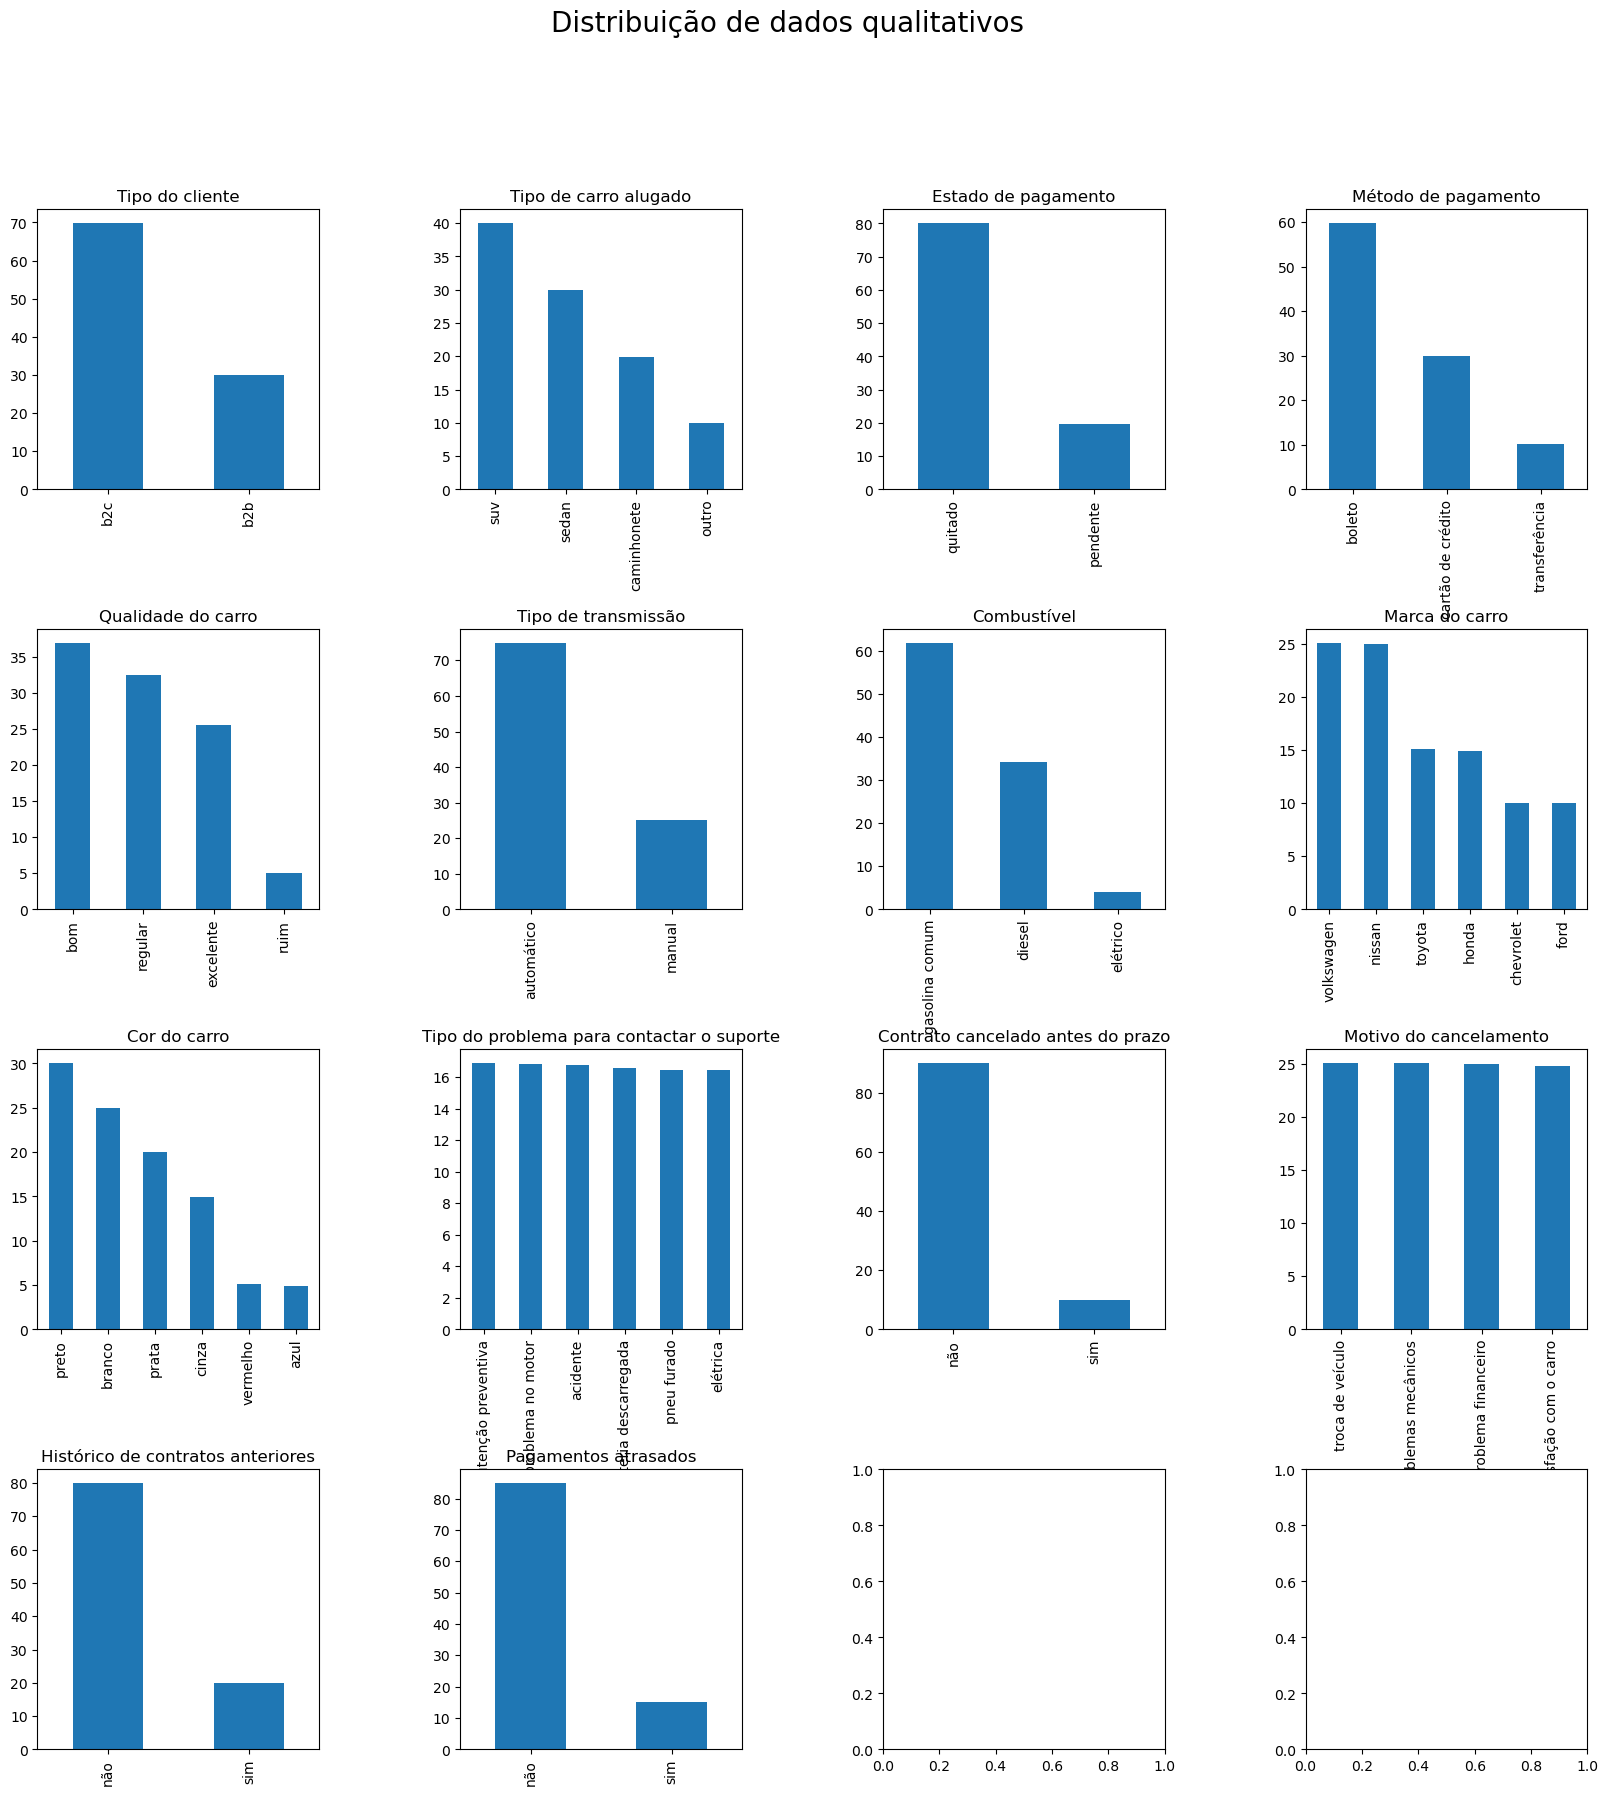

In [58]:
# Lista das colunas qualitativas do db_alugueis que podem agregar em analises futuras
colunas_qualitativas = ['Tipo do cliente', 'Tipo de carro alugado','Estado de pagamento', 'Método de pagamento',
                         'Qualidade do carro', 'Tipo de transmissão', 'Combustível',
                         'Marca do carro', 'Cor do carro','Tipo do problema para contactar o suporte',
                         'Contrato cancelado antes do prazo', 'Motivo do cancelamento','Histórico de contratos anteriores', 'Pagamentos atrasados']

# Realizar um plot de barras para cada coluna qualitativa, usando subplot para poder vizualizar todas juntas
# Quero adicionar espaços entre os gráficos, então vou usar o método subplots_adjust() para ajustar o espaço entre eles
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)
for col, ax in zip(colunas_qualitativas, axs.ravel()):
    (db_alugueis[col].value_counts(True) * 100).plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()


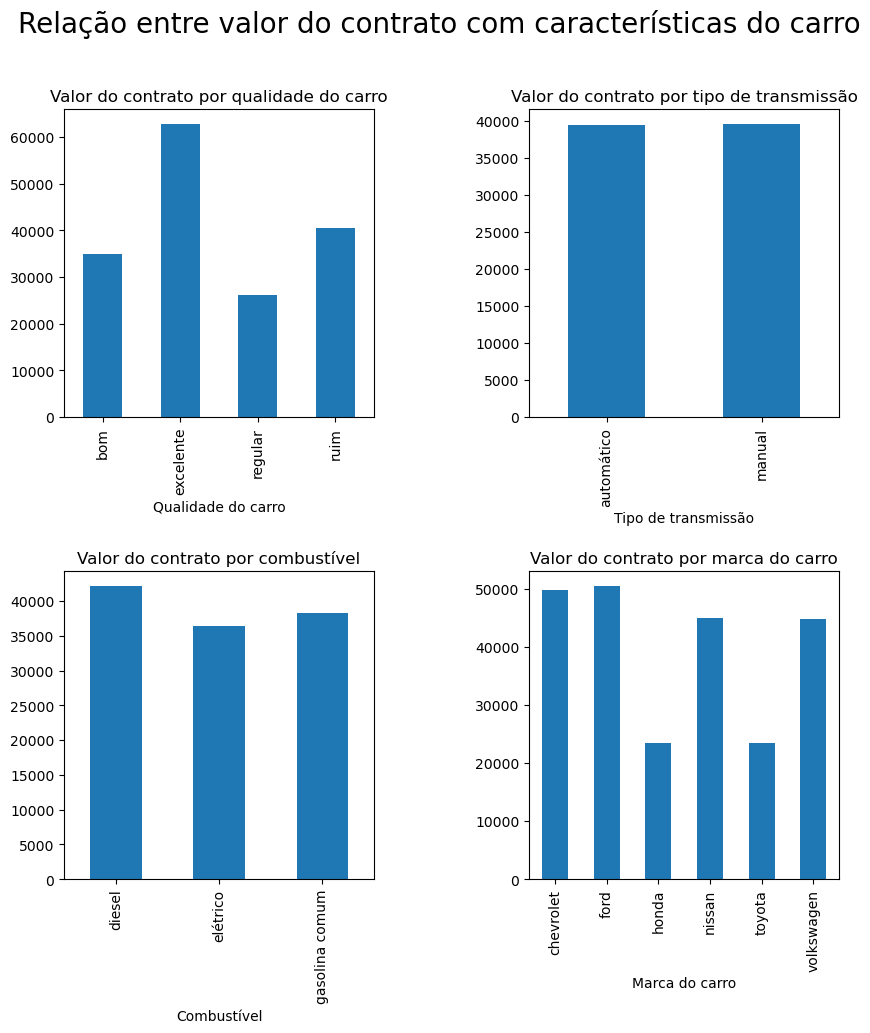

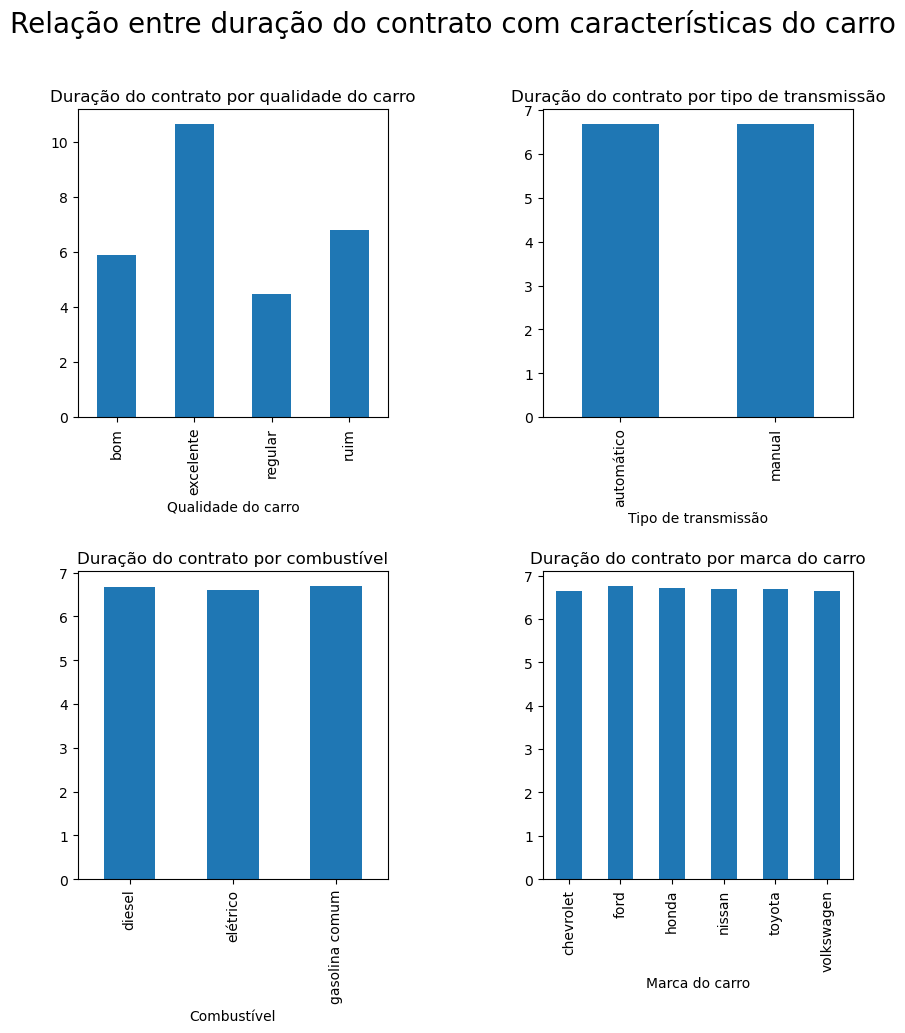

In [36]:
# Entendendo a relação do valor do contrato com algumas caracteristicas do carro
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Relação entre valor do contrato com características do carro', fontsize=20)
db_alugueis.groupby('Qualidade do carro')['Valor do contrato do aluguel'].mean().plot(kind='bar', ax=axs[0, 0], title='Valor do contrato por qualidade do carro')
db_alugueis.groupby('Tipo de transmissão')['Valor do contrato do aluguel'].mean().plot(kind='bar', ax=axs[0, 1], title='Valor do contrato por tipo de transmissão')
db_alugueis.groupby('Combustível')['Valor do contrato do aluguel'].mean().plot(kind='bar', ax=axs[1, 0], title='Valor do contrato por combustível')
db_alugueis.groupby('Marca do carro')['Valor do contrato do aluguel'].mean().plot(kind='bar', ax=axs[1, 1], title='Valor do contrato por marca do carro')
plt.show()

# Entendendo a relação da duração com algumas caracteristicas do carro
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Relação entre duração do contrato com características do carro', fontsize=20)
db_alugueis.groupby('Qualidade do carro')['Tempo de aluguel'].mean().plot(kind='bar', ax=axs[0, 0], title='Duração do contrato por qualidade do carro')
db_alugueis.groupby('Tipo de transmissão')['Tempo de aluguel'].mean().plot(kind='bar', ax=axs[0, 1], title='Duração do contrato por tipo de transmissão')
db_alugueis.groupby('Combustível')['Tempo de aluguel'].mean().plot(kind='bar', ax=axs[1, 0], title='Duração do contrato por combustível')
db_alugueis.groupby('Marca do carro')['Tempo de aluguel'].mean().plot(kind='bar', ax=axs[1, 1], title='Duração do contrato por marca do carro')
plt.show()



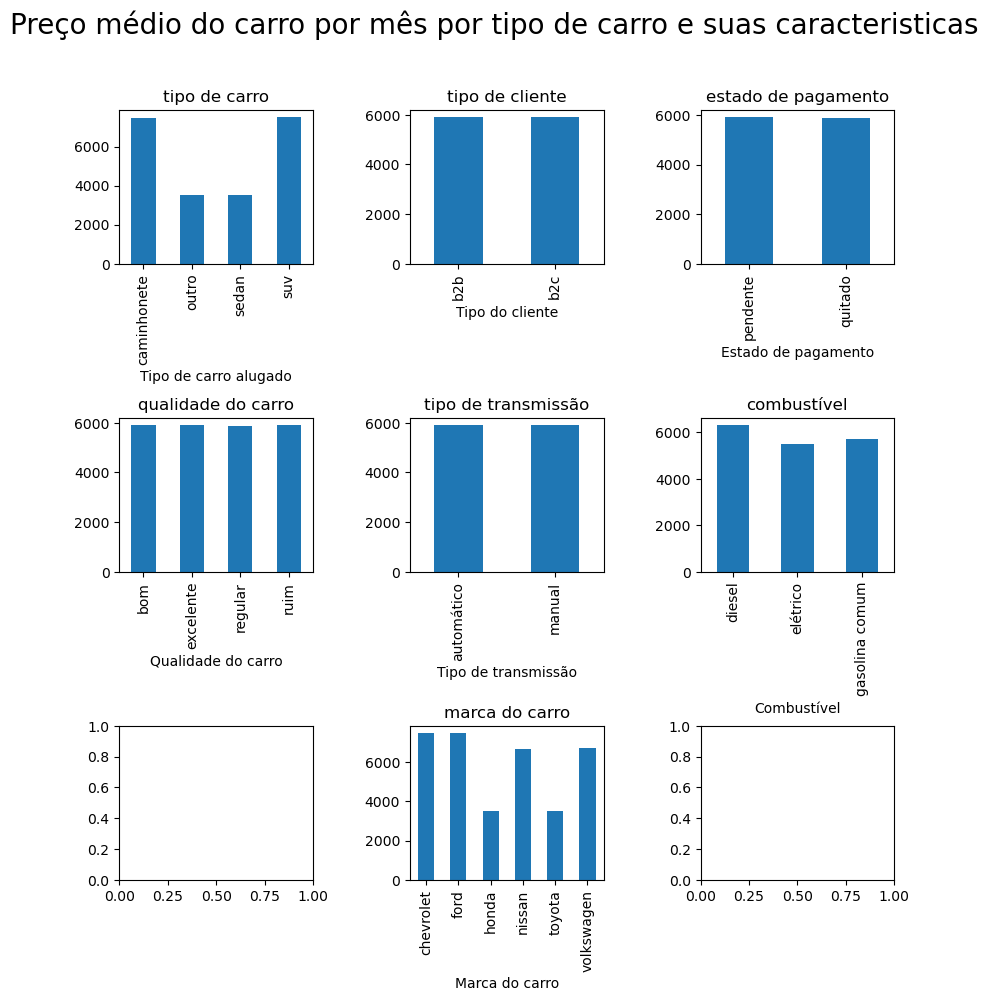

In [37]:
# Entendendo o preço médio do carro por mês para cada tipo de carro e suas caracterisitcas, tipo de cliente, Estado de pagamento
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
fig.subplots_adjust(hspace=1, wspace=0.5)
fig.suptitle('Preço médio do carro por mês por tipo de carro e suas caracteristicas', fontsize=20)
db_alugueis.groupby('Tipo de carro alugado')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[0,0], title='tipo de carro')
db_alugueis.groupby('Tipo do cliente')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[0,1], title='tipo de cliente')
db_alugueis.groupby('Estado de pagamento')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[0,2], title='estado de pagamento')
db_alugueis.groupby('Qualidade do carro')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[1, 0], title='qualidade do carro')
db_alugueis.groupby('Tipo de transmissão')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[1, 1], title='tipo de transmissão')
db_alugueis.groupby('Combustível')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[1, 2], title='combustível')
db_alugueis.groupby('Marca do carro')['Valor médio do carro por mês'].mean().plot(kind='bar', ax=axs[2, 1], title='marca do carro')
plt.show()



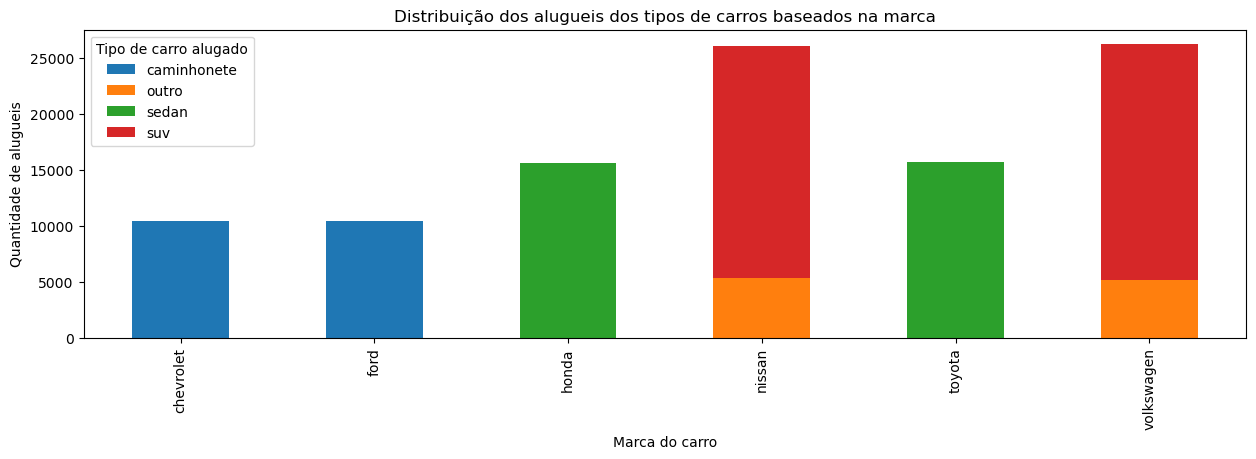

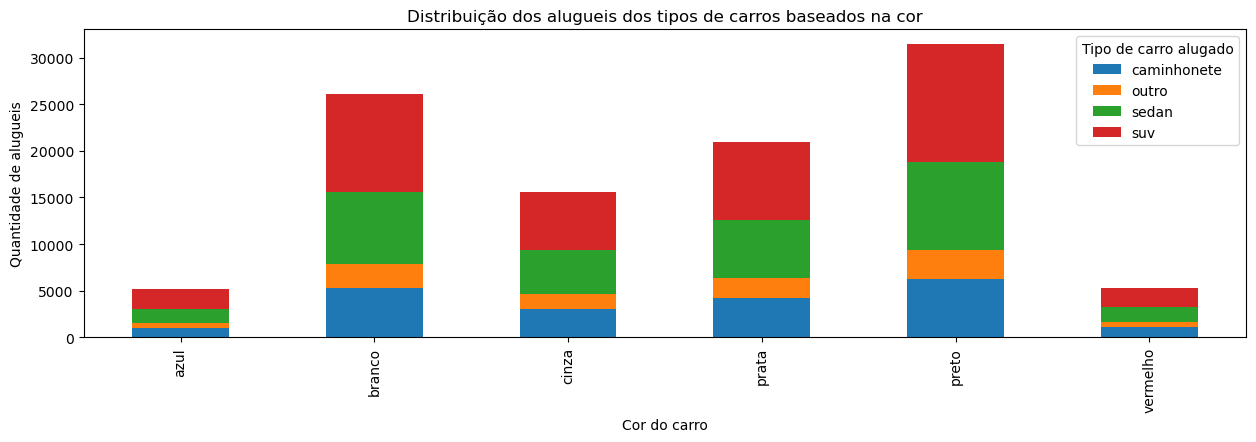

In [38]:
# Distribuição dos alugueis dos tipos de carros baseados na marca:
# Entendendo a quantidade de alugueis de cada tipo de carro para cada marca
# Vou criar um gráfico histograma para visualizar a distribuição
fig, ax = plt.subplots(figsize=(15, 4))
db_alugueis.groupby(['Marca do carro', 'Tipo de carro alugado']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Distribuição dos alugueis dos tipos de carros baseados na marca')
ax.set_xlabel('Marca do carro')
ax.set_ylabel('Quantidade de alugueis')
plt.show()

# Distribuição dos alugueis dos tipos de carros baseados na cor:
# Entendendo a quantidade de alugueis de cada tipo de carro para cada cor
# Vou criar um gráfico histograma para visualizar a distribuição
fig, ax = plt.subplots(figsize=(15, 4))
db_alugueis.groupby(['Cor do carro', 'Tipo de carro alugado']).size().unstack().plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Distribuição dos alugueis dos tipos de carros baseados na cor')
ax.set_xlabel('Cor do carro')
ax.set_ylabel('Quantidade de alugueis')
plt.show()



### Conclusões iniciais com pequena análise

- O maior perfil de cliente é o B2C, entretanto 30% é B2B, o que pode ser um bom nicho de mercado para explorar, pois são cliente que tem maior potencial de renovação de contrato, e maior valor de contrato por um tempo maior.

- O Histórico de contratos anteriores é um fator que influencia muito no valor do contrato, devido aos descontos dados, mas mesmo assim somente cerca de 20% dos clientes tem histórico de contratos anteriores. Vale a pena Analisar quantos ids de clientes se repetem para entender se o histórico de contratos anteriores é um fator que influencia na renovação de contrato. **Ponto importante de ser analisado, pois a retenção de clientes é mais barata que a aquisição de novos clientes, e no momento não está muito alta**

- A média de Satisfação do cliente é de 4.05 o que é um bom indicativo, ainda maais com um desvio padrão de 1.16, o que indica que a maioria das avaliações estão entre 3 e 5 (a cima da média), logo fica o questionamento: Por que poucos cliente renovaram? a Empresa é muito nova para ter tido muitas renovações? ou a empresa não está conseguindo fidelizar os clientes por algum outro motivo sem ser a satisfacao do cliente?

- A média de valor do contrato é de 40mil reais, entretanto como o tempo varia nos contratos é interessante analisar o preço por mês.

- A idade média dos carros é de 3.71, entretanto a quilometragem média é de 66000 Km

- Os carros mais alugados são carros modernos, com cores neutras, com cambio automatico, normalmente SUV ou sedans, com combustivel a gasolina, e com qualidade de carro acima de regular.

- As marcas principais são Volkswagen e Nissan

In [39]:
# Para aprofundar um pouco mais nossa analise, vamos separar o database em dois, um com o tipo de cliente B2B e outro com o tipo de cliente B2C
db_alugueis_b2b = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2b']
db_alugueis_b2c = db_alugueis[db_alugueis['Tipo do cliente'] == 'b2c']


### Mesma Analise, pórem separando por tipo de cliente

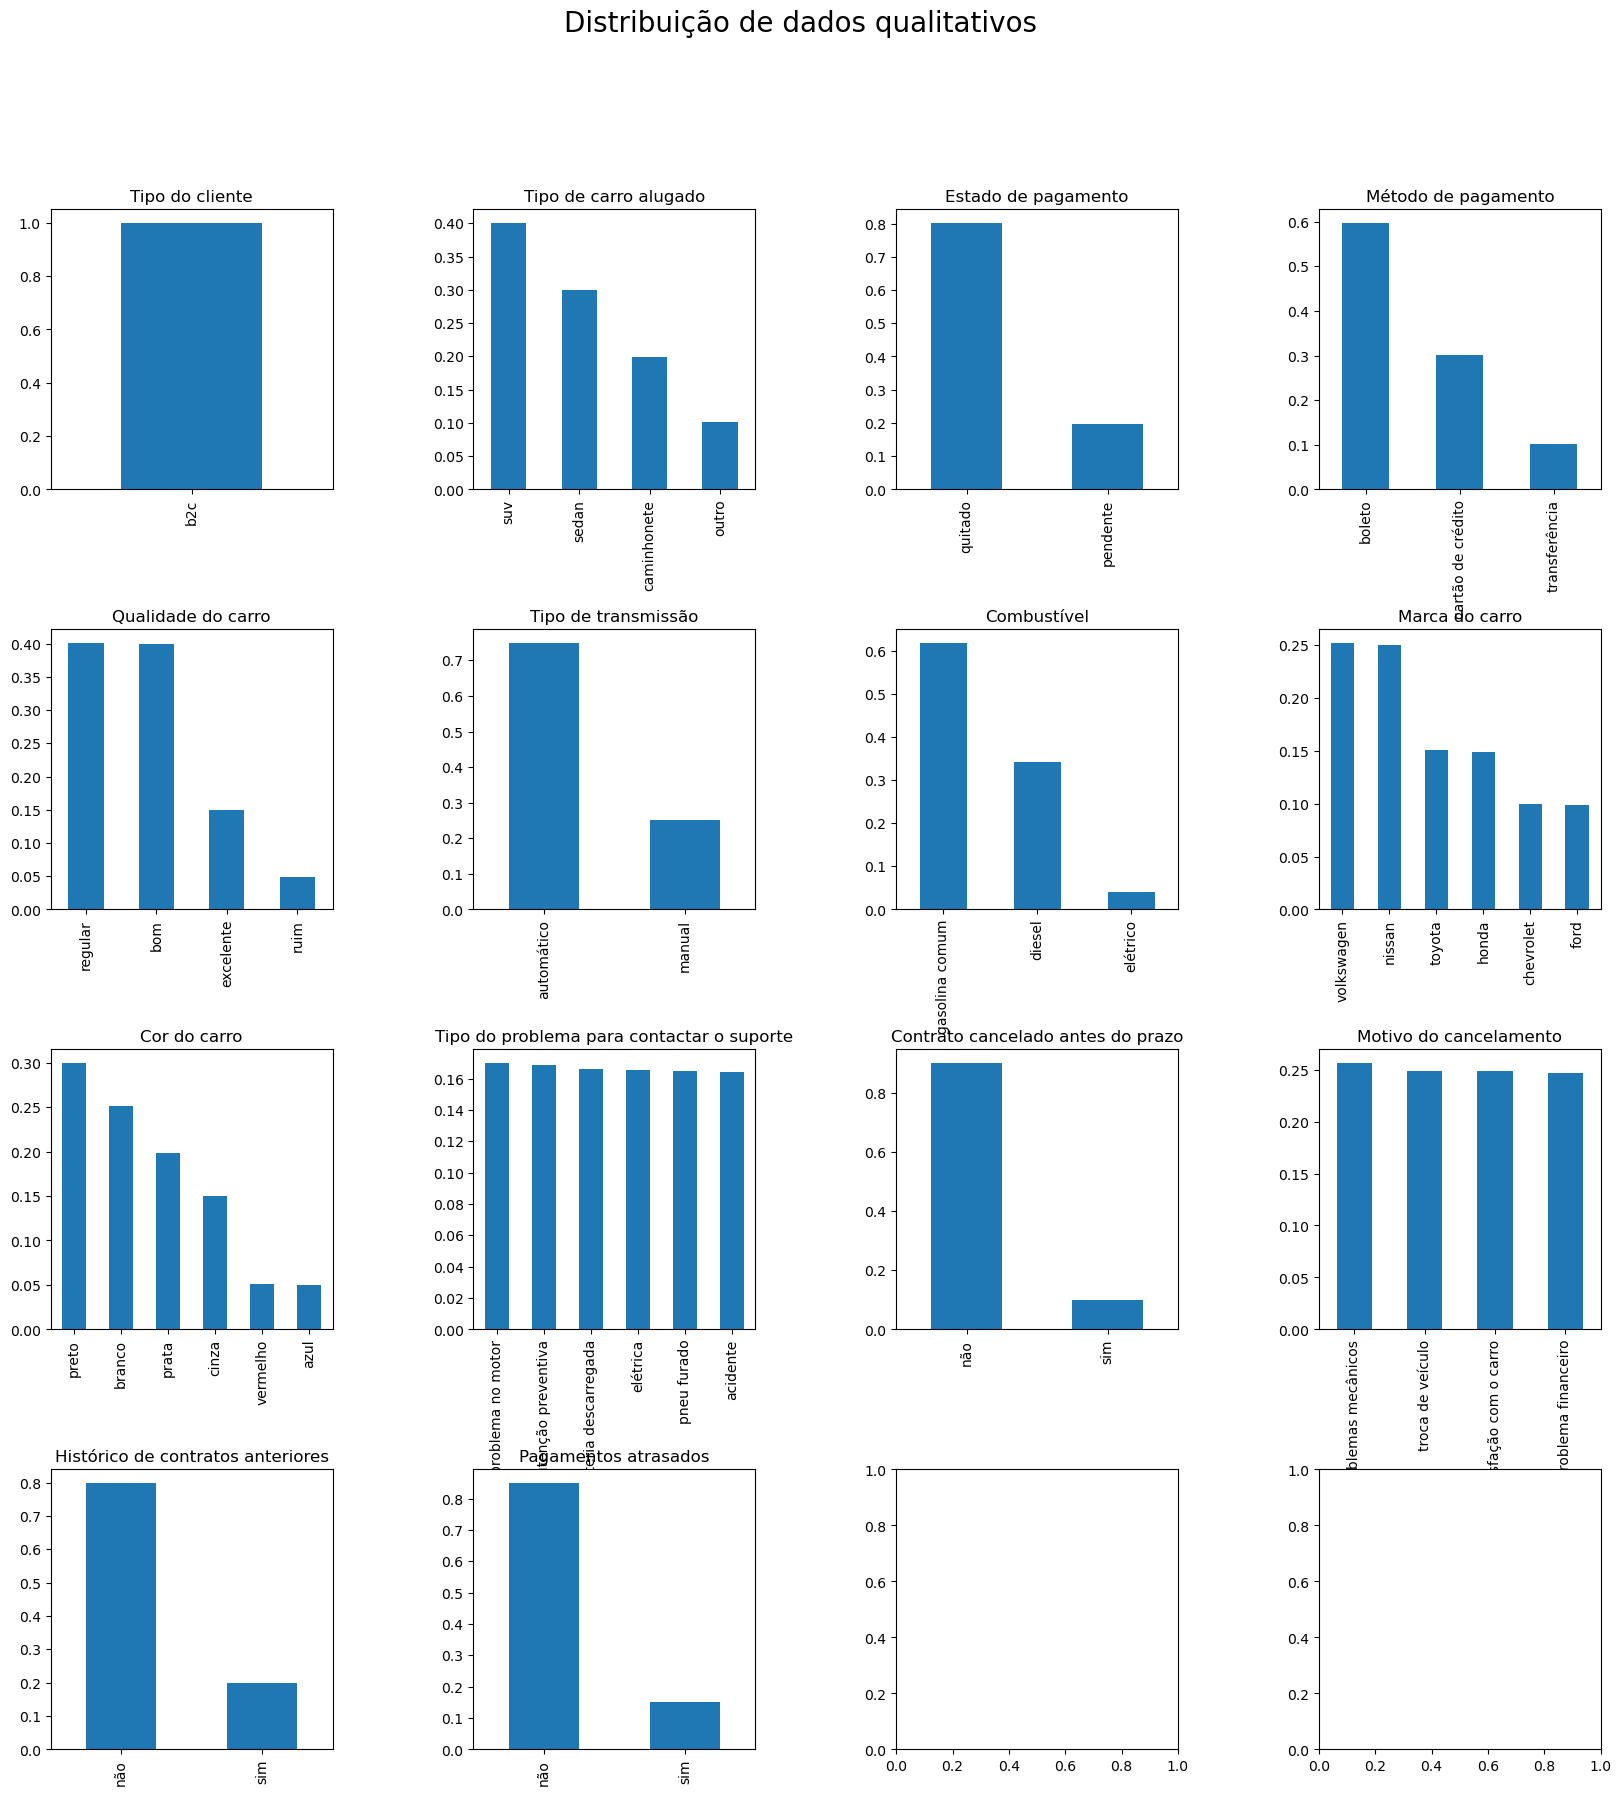

,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Interações com o suporte,Satisfação do cliente,Desconto aplicado no contrato,Valor médio do carro por mês
count,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00,73112.00
mean,41737.44,2.59,15305.59,66169.63,3.71,0.50,4.06,9.99,5903.07
std,24108.98,1.90,13455.28,40062.86,1.87,0.87,1.15,6.07,2320.06
min,1.00,1.00,2000.00,15000.00,1.00,0.00,1.00,0.00,2000.00
25%,20885.75,1.00,5812.00,32411.00,2.00,0.00,3.00,5.00,3883.00
50%,41639.00,1.00,9281.00,49969.50,4.00,0.00,5.00,10.00,5830.50
75%,62616.75,3.00,22116.00,99916.25,5.00,1.00,5.00,15.00,7920.00
max,83649.00,6.00,60000.00,149998.00,7.00,3.00,5.00,20.00,10000.00


In [59]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)

for col, ax in zip(colunas_qualitativas, axs.ravel()):
    db_alugueis_b2c[col].value_counts(True).plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()

db_alugueis_b2c.describe().round(2)

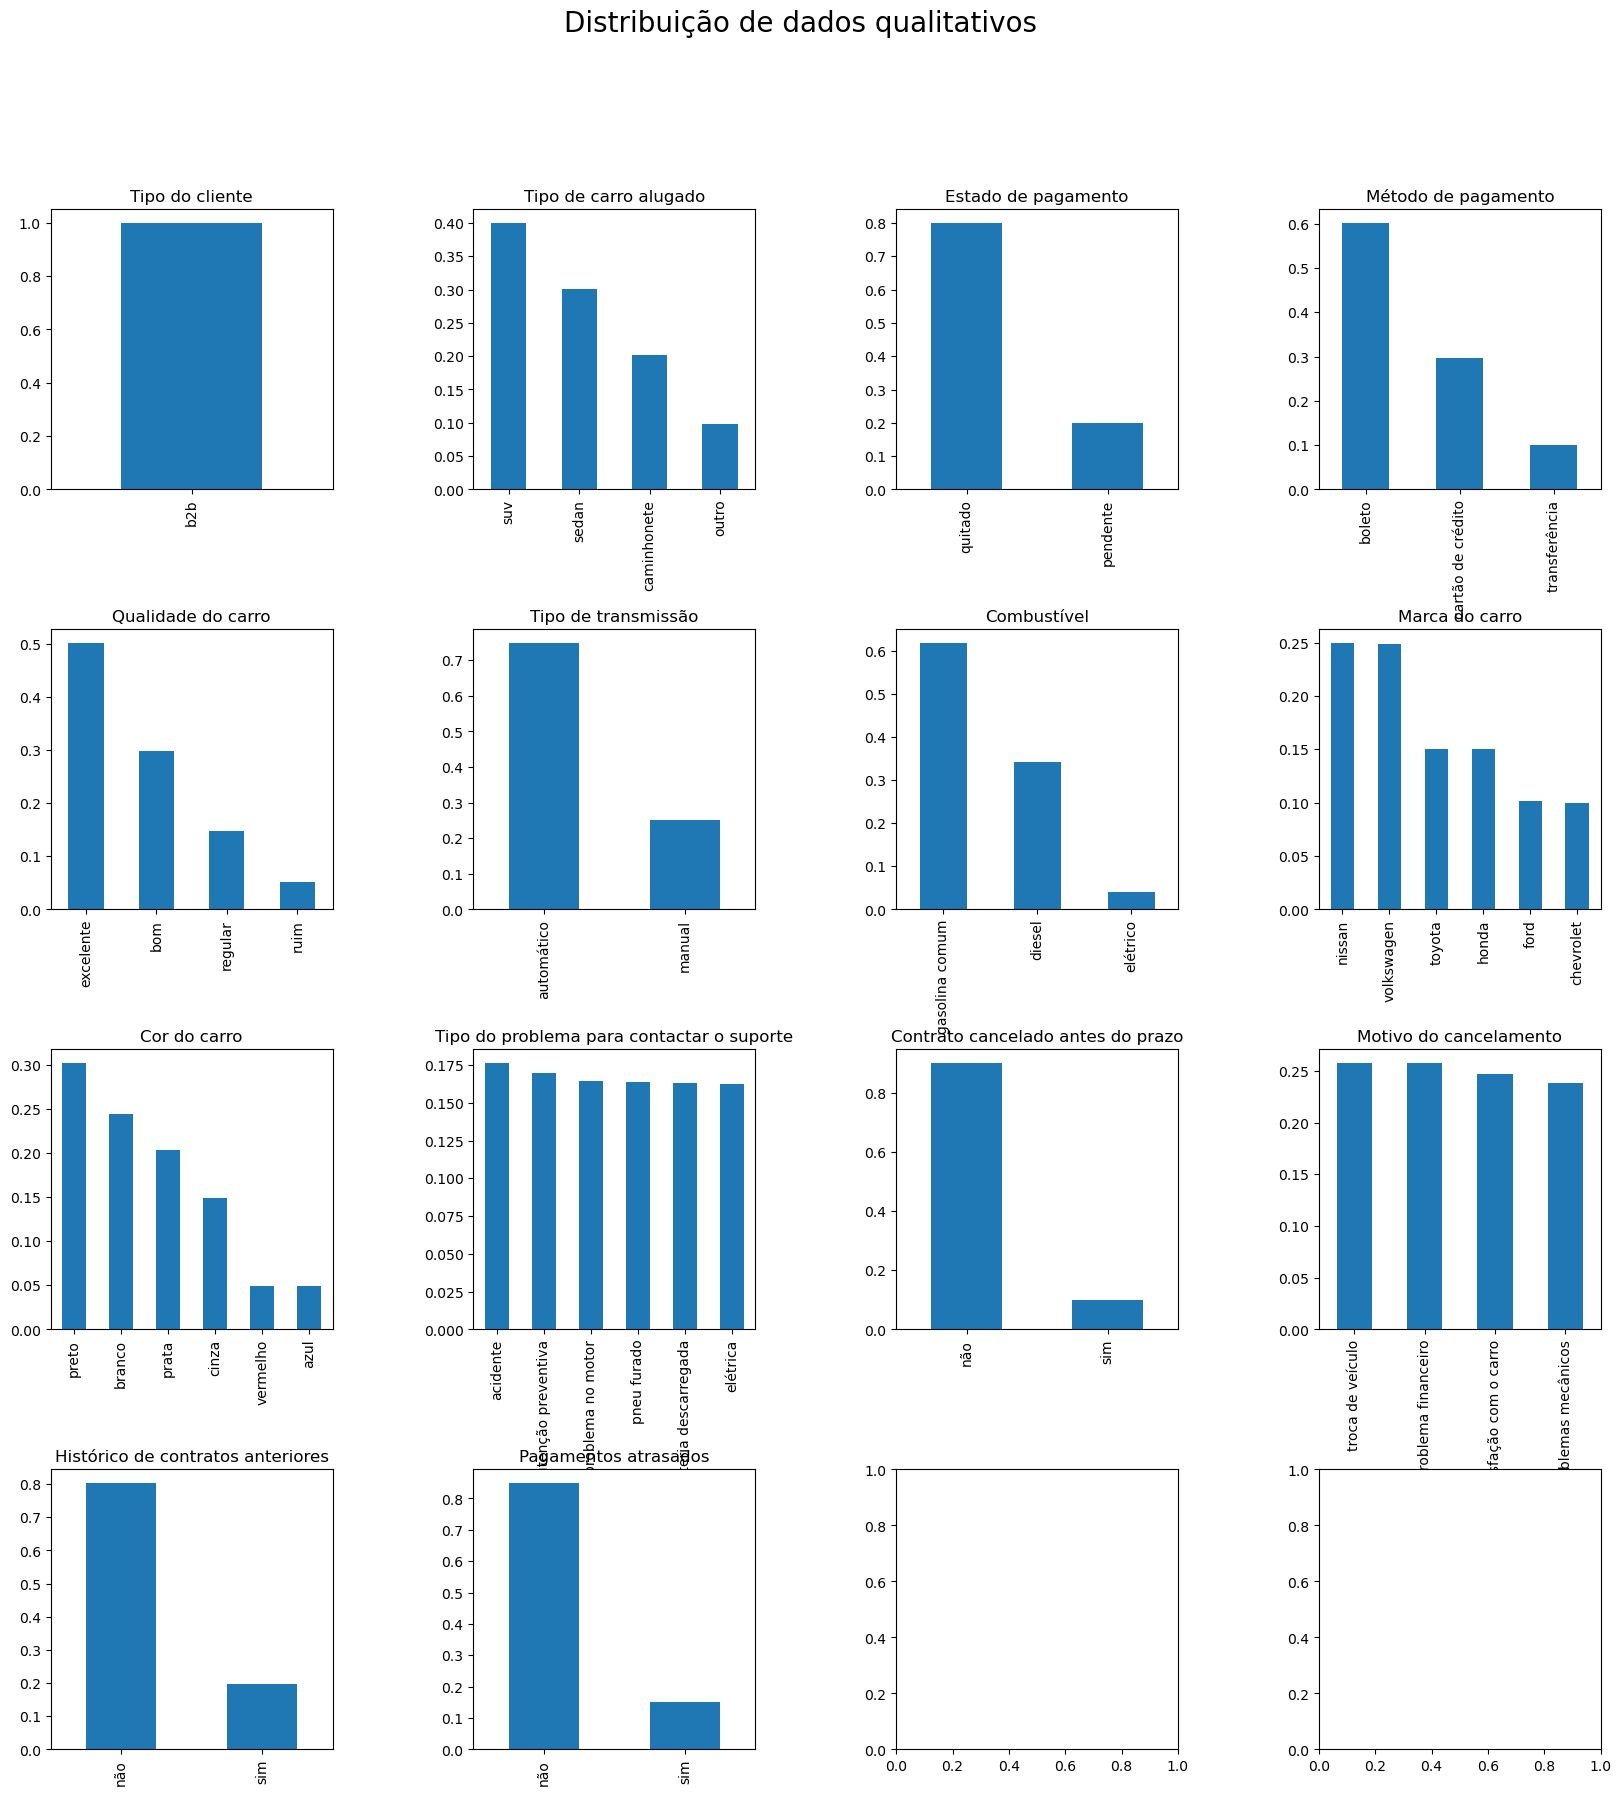

,ID do cliente,Tempo de aluguel,Valor do contrato do aluguel,Quilometragem do carro,Idade do carro,Interações com o suporte,Satisfação do cliente,Desconto aplicado no contrato,Valor médio do carro por mês
count,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00,31452.00
mean,41712.95,16.20,95769.07,66172.15,3.70,0.50,4.04,10.00,5908.01
std,24088.89,4.68,48112.65,40174.19,1.88,0.87,1.16,6.04,2324.62
min,3.00,12.00,24000.00,15005.00,1.00,0.00,1.00,0.00,2000.00
25%,20960.00,12.00,58128.00,32231.75,2.00,0.00,3.00,5.00,3884.00
50%,41508.50,18.00,88026.00,49937.00,4.00,0.00,4.00,10.00,5833.00
75%,62617.00,18.00,119091.00,99819.50,5.00,1.00,5.00,15.00,7923.25
max,83649.00,24.00,240000.00,149998.00,7.00,3.00,5.00,20.00,10000.00


In [60]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Distribuição de dados qualitativos', fontsize=20)

for col, ax in zip(colunas_qualitativas, axs.ravel()):
    db_alugueis_b2b[col].value_counts(True).plot(kind='bar', ax=ax, title=col)
    ax.set_xlabel('')
plt.show()

db_alugueis_b2b.describe().round(2)


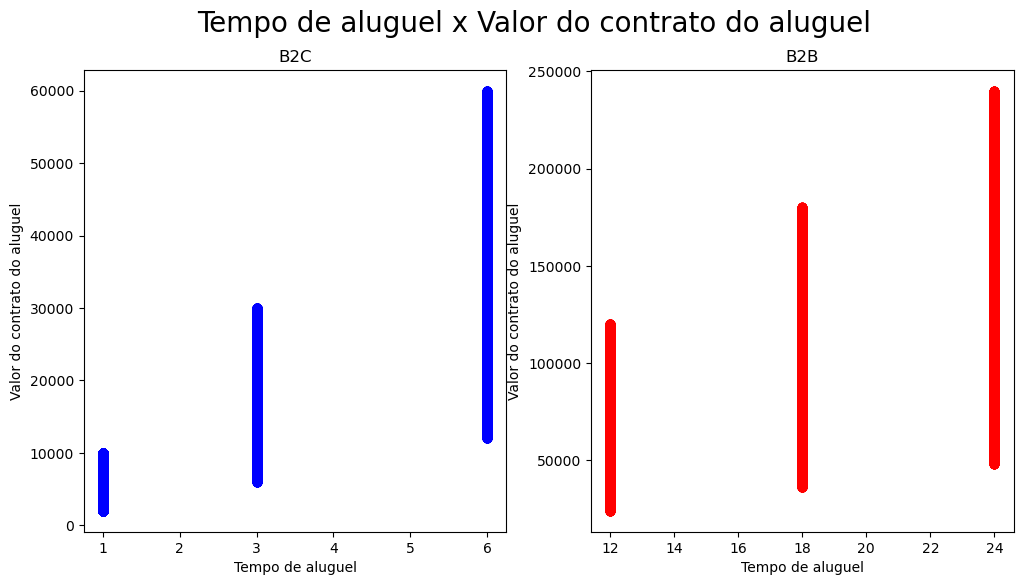

In [42]:
#Quero plotar dois gráficos, um do lado do outro
# Grafico do Tempo de aluguel x Valor do contrato do aluguel, para cliente B2B e B2C
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Tempo de aluguel x Valor do contrato do aluguel', fontsize=20)

axs[0].scatter(db_alugueis_b2c['Tempo de aluguel'], db_alugueis_b2c['Valor do contrato do aluguel'], color='blue')
axs[0].set_title('B2C')
axs[0].set_xlabel('Tempo de aluguel')
axs[0].set_ylabel('Valor do contrato do aluguel')

axs[1].scatter(db_alugueis_b2b['Tempo de aluguel'], db_alugueis_b2b['Valor do contrato do aluguel'], color='red')
axs[1].set_title('B2B')
axs[1].set_xlabel('Tempo de aluguel')
axs[1].set_ylabel('Valor do contrato do aluguel')
plt.show()


- Cliente B2B só realizam contratos a cima de 1 ano enquanto B2C realizam contratos de 6 meses ou menos.

### Analise da Receita, supondo que os contratos quitados foram pagos no mês em que o alugel foi iniciado

    Aqui nós temos o objetivo de entender a composição da receita, poara entender como ela está andando, além disso queremos entender qual o perfil de cliente que mais gera receita, e se a empresa está conseguindo fidelizar os clientes que mais geram receita.

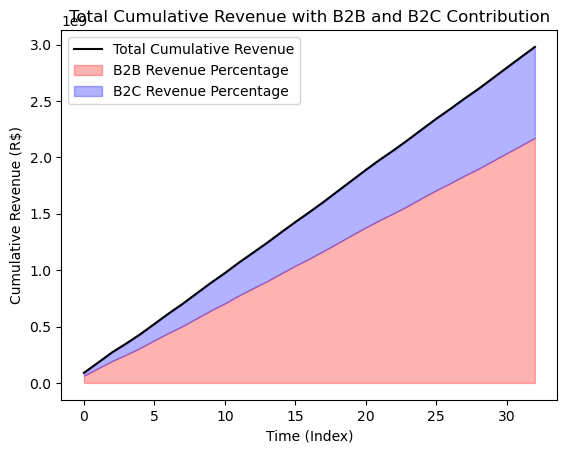

In [43]:
# Analise da receita basica total acumulativa no tempo, desde o começo da empresa, e explorar a porcentagem de receita de cada tipo de cliente
# Plotando o gráfico da Receita cumulativa total ao longo do tempo, analisando a receita mensal, e a porcentagem de receita de cada tipo de cliente
# A coluna valor do contrato, é o valor final fechado, já incluindo desconto e tempo de aluguel
# Plotando o gráfico da Receita cumulativa total ao longo do tempo (um gráfico em baixo do outro)
# Analisando a porcentagem de receita de cada tipo de cliente


# Step 1: Extract month and year from 'Data de início do aluguel'
db_alugueis['Mes'] = db_alugueis['Data de início do aluguel'].dt.month
db_alugueis['Ano'] = db_alugueis['Data de início do aluguel'].dt.year

# Step 2: Filter out rentals that were cancelled
db_alugueis_filtered = db_alugueis[(db_alugueis['Contrato cancelado antes do prazo'] != 'sim') & (db_alugueis['Estado de pagamento'] != 'pendente')]

# Step 3: Group by year, month, and customer type, then calculate total revenue for each group
monthly_revenue = db_alugueis_filtered.groupby(['Mes', 'Ano', 'Tipo do cliente'])['Valor do contrato do aluguel'].sum().reset_index()

# Step 4: Create two separate DataFrames for B2B and B2C
monthly_revenue_b2b = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2b'].copy()
monthly_revenue_b2c = monthly_revenue[monthly_revenue['Tipo do cliente'] == 'b2c'].copy()

# Step 5: Calculate cumulative revenue for B2B and B2C clients
monthly_revenue_b2b['Cumulative_B2B'] = monthly_revenue_b2b['Valor do contrato do aluguel'].cumsum()
monthly_revenue_b2c['Cumulative_B2C'] = monthly_revenue_b2c['Valor do contrato do aluguel'].cumsum()

# Step 6: Merge the two DataFrames (B2B and B2C) on Year and Month, fill missing values with 0
merged_revenue = pd.merge(monthly_revenue_b2b[['Ano', 'Mes', 'Cumulative_B2B']],
                          monthly_revenue_b2c[['Ano', 'Mes', 'Cumulative_B2C']],
                          on=['Ano', 'Mes'], how='outer').fillna(0)

# Step 7: Calculate the total cumulative revenue and percentage contributions for each type
merged_revenue['Total_Cumulative'] = merged_revenue['Cumulative_B2B'] + merged_revenue['Cumulative_B2C']
merged_revenue['Percentage_B2B'] = (merged_revenue['Cumulative_B2B'] / merged_revenue['Total_Cumulative']) * 100
merged_revenue['Percentage_B2C'] = (merged_revenue['Cumulative_B2C'] / merged_revenue['Total_Cumulative']) * 100

# Plot total cumulative revenue
plt.plot(merged_revenue['Total_Cumulative'], label='Total Cumulative Revenue', color='black')

# Shade the area for B2B and B2C percentages
plt.fill_between(range(len(merged_revenue)), 0, merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 color='red', alpha=0.3, label='B2B Revenue Percentage')
plt.fill_between(range(len(merged_revenue)), 
                 merged_revenue['Total_Cumulative'] * (merged_revenue['Percentage_B2B'] / 100), 
                 merged_revenue['Total_Cumulative'], color='blue', alpha=0.3, label='B2C Revenue Percentage')

plt.title('Total Cumulative Revenue with B2B and B2C Contribution')
plt.xlabel('Time (Index)')
plt.ylabel('Cumulative Revenue (R$)')
plt.legend()
plt.show()


- Nota-se que a maior parte da Receita de origina de contratos de clientes do tipo B2B, entretanto a maior parte dos contratos são de clientes do tipo B2C, o que indica que os contratos de B2B são mais valiosos.

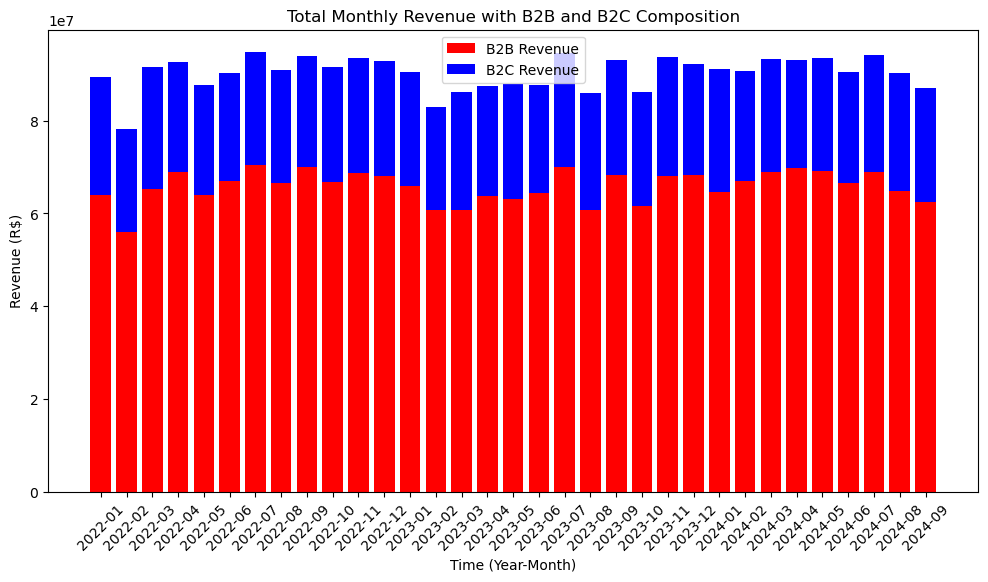

In [44]:
# Agora vamos analisar a receita mensal durante a vida da empresa, entendendo a composição da receita de cada tipo de cliente

# Step 3: Pivot the data to have B2B and B2C revenues as separate columns
pivot_revenue = monthly_revenue.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Valor do contrato do aluguel', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_revenue['Year_Month'] = pivot_revenue.index.get_level_values('Ano').astype(str) + '-' + pivot_revenue.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly revenue
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2b'], label='B2B Revenue', color='red')
plt.bar(pivot_revenue['Year_Month'], pivot_revenue['b2c'], bottom=pivot_revenue['b2b'], label='B2C Revenue', color='blue')

plt.title('Total Monthly Revenue with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Revenue (R$)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


- Percebe-se que a maior fonte de receita é oriunda de contratos B2B, que são mais longos e valem mais, agora vamos analisar a demanda para ver como estão distribuidos

### Analise da demanda, Vamos entender quantos carros são alugados por mês por cada perfil de cliente

    Aqui queremos realizar uma conexão com a ánalise do faturamento, Queremos entender o ticket médio de clientes B2B e B2C, e entender se a empresa está conseguindo fidelizar os clientes que mais geram receita.
    Além disso, queremos entneder como a empresa está gerindo a frota, como os contratos estão sendo distribuidos, e se a empresa está conseguindo atender a demanda, e ao mesmo tempo e ela está com um estoque muito alto, o que pode ser um problema, pois estara perdendo muito poder de barganha com os clientes B2B, que são contratos mais longos, que caso não sejam renovados, podem gerar um grande prejuizo, especialmente se não existir uma demanda de clientes B2C para suprir.

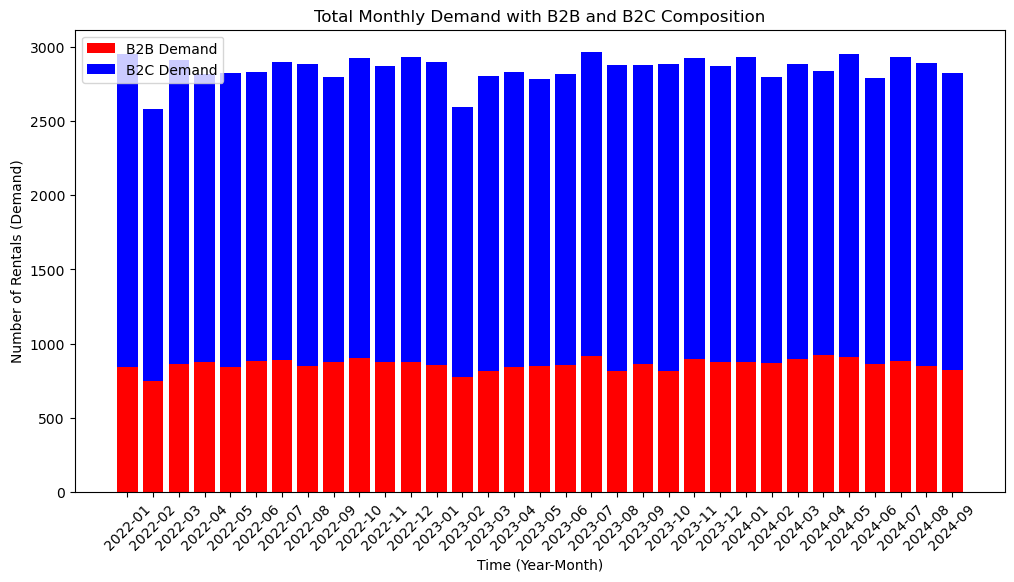

In [45]:
# Step 1: Filter out rentals where the payment is pending and rentals that were cancelled
db_alugueis_filtered = db_alugueis[db_alugueis['Contrato cancelado antes do prazo'] != 'sim']

# Step 2: Group the data by 'Year', 'Month', and 'Tipo do cliente' and count the number of rentals (demand)
monthly_demand = db_alugueis_filtered.groupby(['Ano', 'Mes', 'Tipo do cliente']).size().reset_index(name='Demand')

# Step 3: Pivot the data to have B2B and B2C demand as separate columns
pivot_demand = monthly_demand.pivot_table(index=['Ano', 'Mes'], columns='Tipo do cliente', values='Demand', fill_value=0)

# Combine Year and Month into a single string column to use as the x-axis
pivot_demand['Year_Month'] = pivot_demand.index.get_level_values('Ano').astype(str) + '-' + pivot_demand.index.get_level_values('Mes').astype(str).str.zfill(2)

# Step 4: Plot the stacked bar chart for monthly demand
plt.figure(figsize=(12, 6))

# Plotting B2B and B2C demand as stacked bars, using the combined 'Year_Month' for the x-axis
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2b'], label='B2B Demand', color='red')
plt.bar(pivot_demand['Year_Month'], pivot_demand['b2c'], bottom=pivot_demand['b2b'], label='B2C Demand', color='blue')

plt.title('Total Monthly Demand with B2B and B2C Composition')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Number of Rentals (Demand)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()


#### Agora iremos relizar um modelo de previsão da demanda para o próximo ano

Será utilizado o modelo do facebook Prophet, que é um modelo de previsão de séries temporais, utilizado para prever séries temporais com sazonalidade e com tendência. O modelo de previsão foi realizado no arquivo PrevisoesProphet.ipynb, uma vez que foi necessário utilizar o jupyter notebook para realizar a previsão, visto que não foi possível baixar o pacote prophet e pystan no ambiente do VSCode.

## Clusterização de clientes

    O foco dessa seção é seperar os clientes em clusters para entender quais são os perfis de clientes que mais alugam carros mais caros e mias baratos, mais frequente e menos frequente ...

In [46]:
# Step 1: Handle missing or unexpected values in 'Pagamentos atrasados'
# Map 'sim' to 1 and 'não' to 0, and fill NaN with 0 for safety
db_filtrado = db_alugueis.copy()
db_filtrado['Pagamentos atrasados'] = db_filtrado['Pagamentos atrasados'].map({'sim': 1, 'não': 0}).fillna(0)

# Step 2: Group by 'ID do cliente' to aggregate data at the customer level
customer_data = db_filtrado.groupby('ID do cliente').agg(
    # Total revenue per customer
    total_revenue=('Valor do contrato do aluguel', 'sum'),
    
    # Number of rentals per customer
    num_rentals=('ID do cliente', 'count'),  # Count number of rentals by 'ID do cliente'
    
    # Customer type (mode of 'Tipo do cliente')
    customer_type=('Tipo do cliente', lambda x: x.mode()[0]),
    
    # Most frequent car type rented (mode of 'Tipo de carro alugado')
    most_frequent_car_type=('Tipo de carro alugado', lambda x: x.mode()[0]),
    
    # Average contract value (average revenue per rental)
    avg_contract_value=('Valor do contrato do aluguel', 'mean'),
    
    # Count of delayed payments (now it's numeric and will sum correctly)
    num_delayed_payments=('Pagamentos atrasados', 'sum'),
    
    # First rental date
    first_rental_date=('Data de início do aluguel', 'min'),
    
    # Most recent rental date
    most_recent_rental_date=('Data de início do aluguel', 'max')
).reset_index()

# Step 3: Calculate rental durations
# Calculate the rental duration for each rental in days and then aggregate it
db_alugueis['rental_duration'] = (db_alugueis['Data final do aluguel'] - db_alugueis['Data de início do aluguel']).dt.days

# Step 4: Aggregate the average and total rental duration by customer
rental_duration_agg = db_alugueis.groupby('ID do cliente').agg(
    avg_rental_duration=('rental_duration', 'mean'),
    total_rental_duration=('rental_duration', 'sum')
).reset_index()

# Step 5: Merge the rental duration data back into the customer_data DataFrame
customer_data = pd.merge(customer_data, rental_duration_agg, on='ID do cliente')

# Step 6: Calculate additional features like customer tenure
# Customer tenure in days (difference between first and most recent rental)
customer_data['customer_tenure'] = (customer_data['most_recent_rental_date'] - customer_data['first_rental_date']).dt.days

# Step 7: Drop unnecessary columns (optional)
customer_data = customer_data.drop(columns=['first_rental_date', 'most_recent_rental_date'])

# Step 8: Review the aggregated customer data
display(customer_data.head())


,ID do cliente,total_revenue,num_rentals,customer_type,most_frequent_car_type,avg_contract_value,num_delayed_payments,avg_rental_duration,total_rental_duration,customer_tenure
0,1,25058.0,2,b2c,outro,12529.000000,0,105.0,210,144
1,2,22122.0,1,b2c,caminhonete,22122.000000,0,90.0,90,0
2,3,183378.0,2,b2b,caminhonete,91689.000000,0,360.0,720,206
3,4,22913.0,3,b2c,sedan,7637.666667,1,50.0,150,449
4,5,9106.0,1,b2c,suv,9106.000000,1,30.0,30,0


In [47]:
from sklearn.preprocessing import StandardScaler

# Step 1: Select numerical features for scaling
numerical_features = ['total_revenue', 'num_rentals', 'avg_rental_duration', 
                      'total_rental_duration', 'avg_contract_value', 'num_delayed_payments', 
                      'customer_tenure']

# Step 2: Initialize the scaler
scaler = StandardScaler()

# Step 3: Apply the scaler to the numerical features
scaled_data = scaler.fit_transform(customer_data[numerical_features])

# Step 4: Create a DataFrame with the scaled data, keeping the same column names
scaled_customer_data = pd.DataFrame(scaled_data, columns=numerical_features)

# Step 5: Add back the non-numerical features (e.g., customer_type, most_frequent_car_type)
# We need to include these if we plan to use them in further analysis or keep them for reference
scaled_customer_data['ID do cliente'] = customer_data['ID do cliente']
scaled_customer_data['customer_type'] = customer_data['customer_type']
scaled_customer_data['most_frequent_car_type'] = customer_data['most_frequent_car_type']

# Review the scaled data
display(scaled_customer_data.head())


,total_revenue,num_rentals,avg_rental_duration,total_rental_duration,avg_contract_value,num_delayed_payments,customer_tenure,ID do cliente,customer_type,most_frequent_car_type
0,-0.613111,0.268172,-0.543589,-0.423949,-0.680424,-0.530864,-0.222255,1,b2c,outro
1,-0.653941,-0.805127,-0.628828,-0.784558,-0.438234,-0.530864,-0.752001,2,b2c,caminhonete
2,1.588609,0.268172,0.905470,1.108639,1.318095,-0.530864,0.005830,3,b2b,caminhonete
3,-0.642941,1.341472,-0.856131,-0.604254,-0.803914,1.495006,0.899776,4,b2c,sedan
4,-0.834952,-0.805127,-0.969783,-0.964863,-0.766843,1.495006,-0.752001,5,b2c,suv


,total_revenue,num_rentals,avg_rental_duration,total_rental_duration,avg_contract_value,num_delayed_payments,customer_tenure
0,-0.613111,0.268172,-0.543589,-0.423949,-0.680424,-0.530864,-0.222255
1,-0.653941,-0.805127,-0.628828,-0.784558,-0.438234,-0.530864,-0.752001
2,1.588609,0.268172,0.905470,1.108639,1.318095,-0.530864,0.005830
3,-0.642941,1.341472,-0.856131,-0.604254,-0.803914,1.495006,0.899776
4,-0.834952,-0.805127,-0.969783,-0.964863,-0.766843,1.495006,-0.752001


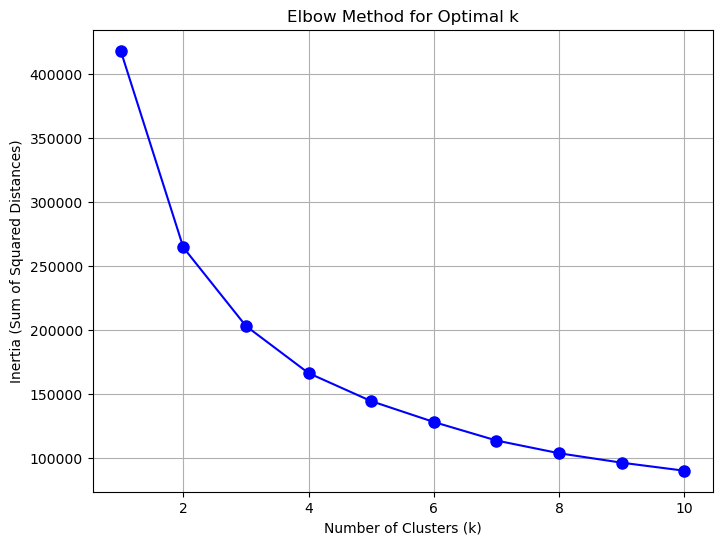

In [48]:
from sklearn.cluster import KMeans
import os

# Step 1: Select numerical features for clustering
numerical_features = ['total_revenue', 'num_rentals', 'avg_rental_duration', 
                      'total_rental_duration', 'avg_contract_value', 'num_delayed_payments', 
                      'customer_tenure']

# Step 2: Ensure all selected features are numeric
customer_data[numerical_features] = customer_data[numerical_features].apply(pd.to_numeric, errors='coerce')

# Step 3: Initialize the scaler and scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data[numerical_features])

# Step 4: Verify the scaled data (ensure it's numeric and well-structured)
display(pd.DataFrame(scaled_data, columns=numerical_features).head())

# Step 5: Set BLAS to use a single thread to avoid threading issues
os.environ["OMP_NUM_THREADS"] = "1"

# Step 6: Use the Elbow Method to find the optimal number of clusters
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Added n_init=10 to control random initialization
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Step 7: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.grid(True)
plt.show()


In [49]:
# from sklearn.metrics import silhouette_score

# # Step 1: Calculate silhouette scores for different values of k
# silhouette_scores = []
# k_range = range(2, 8)  # We start from 2 clusters since silhouette score is undefined for k=1

# for k in k_range:
#     print(f'Calculating silhouette score for k = {k}')
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     cluster_labels = kmeans.fit_predict(scaled_data)
#     silhouette_avg = silhouette_score(scaled_data, cluster_labels)
#     silhouette_scores.append(silhouette_avg)

# # Step 2: Plot the silhouette scores for each k
# plt.figure(figsize=(8, 6))
# plt.plot(k_range, silhouette_scores, 'bo-', markersize=8)
# plt.title('Silhouette Scores for Different k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Average Silhouette Score')
# plt.grid(True)
# plt.show()


In [50]:
from sklearn.cluster import KMeans

# Step 1: Fit K-Means with the optimal number of clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
customer_data['cluster'] = kmeans.fit_predict(scaled_data)  # Assign cluster labels to customers

# Step 2: Analyze the resulting clusters by calculating the average characteristics of each cluster
cluster_analysis = customer_data.groupby('cluster').mean()

# Step 3: Display the cluster analysis results
display(cluster_analysis)

# Optional: Review the data with cluster labels (e.g., total revenue, number of rentals)
display(customer_data[[ 'cluster', 'total_revenue', 'num_rentals', 'avg_rental_duration']].head())


,ID do cliente,total_revenue,num_rentals,avg_contract_value,num_delayed_payments,avg_rental_duration,total_rental_duration,customer_tenure
cluster,,,,,,,,
0,41664.093587,122683.397662,2.923519,42774.044451,0.527376,221.665505,632.496533,552.713361
1,41667.526890,132806.590803,1.365809,100328.109437,0.159695,475.093964,624.983112,79.824370
2,41834.559713,22387.436445,1.346966,16717.594122,0.176266,95.178625,126.510376,88.409069


,cluster,total_revenue,num_rentals,avg_rental_duration
0,2,25058.0,2,105.0
1,2,22122.0,1,90.0
2,1,183378.0,2,360.0
3,0,22913.0,3,50.0
4,2,9106.0,1,30.0


---------------------------------------------------------

#### Analise utilizando o random forest para saber o tipo de carro alugado baseado nas outras features

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Step 1: Prepare the dataset
# Our target (y) is 'Tipo de carro alugado' (type of car rented)
# The features (X) will include various rental and customer attributes

# Drop any rows where 'Tipo de carro alugado' is missing
rf_filter = db_alugueis.dropna(subset=['Tipo de carro alugado'])

# Define the features (X) and target (y)
X = rf_filter[['Tempo de aluguel', 'Valor do contrato do aluguel', 'Estado de pagamento',
                 'Quilometragem do carro', 'Qualidade do carro', 'Tipo de transmissão', 
                 'Combustível', 'Idade do carro', 'Contrato cancelado antes do prazo', 'Tipo do cliente']]
y = rf_filter['Tipo de carro alugado']

# Step 2: Encode categorical features
# We'll use LabelEncoder for categorical features and the target
categorical_columns = ['Qualidade do carro', 'Tipo de transmissão', 'Combustível', 'Contrato cancelado antes do prazo', 'Estado de pagamento', 'Tipo do cliente']
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target variable 'Tipo de carro alugado'
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

# Step 6: Feature Importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", importance_df)

# Step 7: Ranking Car Types by Rental Frequency
car_type_ranking = db_alugueis['Tipo de carro alugado'].value_counts().reset_index()
car_type_ranking.columns = ['Tipo de carro alugado', 'Number of Rentals']
print("\nRanking of Car Types by Rental Frequency:\n", car_type_ranking)


C:\Users\rique\AppData\Local\Temp\ipykernel_19308\1390290458.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Classification Report:
               precision    recall  f1-score   support

 caminhonete       0.56      0.49      0.52      6203
       outro       0.24      0.07      0.10      3117
       sedan       0.75      0.93      0.83      9431
         suv       0.76      0.81      0.79     12619

    accuracy                           0.71     31370
   macro avg       0.58      0.57      0.56     31370
weighted avg       0.67      0.71      0.68     31370


Feature Importances:
                              Feature  Importance
1       Valor do contrato do aluguel    0.508961
3             Quilometragem do carro    0.219548
0                   Tempo de aluguel    0.105165
6                        Combustível    0.054387
7                     Idade do carro    0.047501
4                 Qualidade do carro    0.023279
9                    Tipo do cliente    0.015223
5                Tipo de transmissão    0.009803
2                Estado de pagamento    0.008729
8  Contrato cancelado antes 

In [52]:
# Step 1: Prepare the dataset
# Our target (y) is 'Tipo de carro alugado' (type of car rented)
# The features (X) will include various rental and customer attributes

# Drop any rows where 'Tipo de carro alugado' is missing
db_alugueis = db_alugueis.dropna(subset=['Tipo de carro alugado'])

# Define the features (X) and target (y)
X = db_alugueis[['Tempo de aluguel', 'Valor do contrato do aluguel', 'Estado de pagamento',
                 'Quilometragem do carro', 'Qualidade do carro', 'Tipo de transmissão', 
                 'Combustível', 'Idade do carro', 'Marca do carro', 'Contrato cancelado antes do prazo']]
y = db_alugueis['Tipo de carro alugado']

# Step 2: Encode categorical features
# We'll use LabelEncoder for categorical features and the target
categorical_columns = ['Estado de pagamento', 'Tipo de transmissão', 'Combustível', 'Marca do carro', 'Contrato cancelado antes do prazo', 'Qualidade do carro']
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target variable 'Tipo de carro alugado'
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = rf_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le_y.classes_))

# Step 6: Feature Importance
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print("\nFeature Importances:\n", importance_df)

# Step 7: Ranking Car Types by Rental Frequency
car_type_ranking = db_alugueis['Tipo de carro alugado'].value_counts().reset_index()
car_type_ranking.columns = ['Tipo de carro alugado', 'Number of Rentals']
print("\nRanking of Car Types by Rental Frequency:\n", car_type_ranking)


C:\Users\rique\AppData\Local\Temp\ipykernel_19308\681097175.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])


Classification Report:
               precision    recall  f1-score   support

 caminhonete       1.00      1.00      1.00      6203
       outro       1.00      1.00      1.00      3117
       sedan       1.00      1.00      1.00      9431
         suv       1.00      1.00      1.00     12619

    accuracy                           1.00     31370
   macro avg       1.00      1.00      1.00     31370
weighted avg       1.00      1.00      1.00     31370


Feature Importances:
                              Feature  Importance
8                     Marca do carro    0.627064
1       Valor do contrato do aluguel    0.233326
0                   Tempo de aluguel    0.089286
6                        Combustível    0.022641
3             Quilometragem do carro    0.016487
7                     Idade do carro    0.004494
4                 Qualidade do carro    0.003290
5                Tipo de transmissão    0.001263
2                Estado de pagamento    0.001183
9  Contrato cancelado antes 

---------------------------------------------------------

#### Modelo que retorna as "características do cliente" baseado nas características do carro alugado


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Step 1: Prepare the dataset
# The input features will be the car characteristics (X)
# The target variables will be the client characteristics (y)

# Define the features (X) - car-related features
X = db_alugueis[['Tipo de carro alugado', 'Idade do carro', 'Quilometragem do carro', 'Qualidade do carro',
                 'Tipo de transmissão', 'Combustível', 'Marca do carro', 'Cor do carro']]

# Define the target variables (y) - client-related features
y = db_alugueis[['Tipo do cliente', 'Pagamentos atrasados', 'Histórico de contratos anteriores']]

# Step 2: Encode categorical features
# We'll use LabelEncoder to convert categorical columns into numeric form
categorical_columns_X = ["Qualidade do carro", 'Tipo de carro alugado', 'Tipo de transmissão', 'Combustível', 'Marca do carro', 'Cor do carro']
for col in categorical_columns_X:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Encode the target variables (y) as well
for col in y.columns:
    le_y = LabelEncoder()
    y[col] = le_y.fit_transform(y[col])

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train a Random Forest Classifier with MultiOutputClassifier
rf_model = RandomForestClassifier(random_state=42)
multi_target_rf = MultiOutputClassifier(rf_model, n_jobs=-1)
multi_target_rf.fit(X_train, y_train)

# Step 5: Predict the client characteristics using the test set
y_pred = multi_target_rf.predict(X_test)

# Step 6: Evaluate the model using classification report for each target variable
for i, col in enumerate(y.columns):
    print(f"\nClassification Report for {col}:\n")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i], target_names=le_y.classes_))


C:\Users\rique\AppData\Local\Temp\ipykernel_19308\3182652986.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
C:\Users\rique\AppData\Local\Temp\ipykernel_19308\3182652986.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[col] = le_y.fit_transform(y[col])



Classification Report for Tipo do cliente:

              precision    recall  f1-score   support

         não       0.44      0.39      0.41      9478
         sim       0.75      0.78      0.76     21892

    accuracy                           0.66     31370
   macro avg       0.59      0.58      0.59     31370
weighted avg       0.65      0.66      0.66     31370


Classification Report for Pagamentos atrasados:

              precision    recall  f1-score   support

         não       0.85      0.91      0.88     26723
         sim       0.15      0.09      0.11      4647

    accuracy                           0.79     31370
   macro avg       0.50      0.50      0.50     31370
weighted avg       0.75      0.79      0.77     31370


Classification Report for Histórico de contratos anteriores:

              precision    recall  f1-score   support

         não       0.80      0.86      0.83     25131
         sim       0.20      0.14      0.16      6239

    accuracy            

In [54]:
# Example: Predict client characteristics for a specific car
car_features = pd.DataFrame([{
    'Tipo de carro alugado': 'SUV',
    'Idade do carro': 3,
    'Quilometragem do carro': 40000,
    'Qualidade do carro': 4,
    'Tipo de transmissão': 'Automático',
    'Combustível': 'Gasolina',
    'Marca do carro': 'Toyota',
    'Cor do carro': 'Prata'
}])

# Encode the car features
for col in categorical_columns_X:
    car_features[col] = le.fit_transform(car_features[col])

# Predict client characteristics for the car
client_prediction = multi_target_rf.predict(car_features)
print("Predicted Client Characteristics:", client_prediction)


Predicted Client Characteristics: [[1 0 0]]
